In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

from sklearn.preprocessing import StandardScaler

In [3]:
data = pd.read_csv('final_imp.csv')

In [4]:
import math

def calculate_direction(x1, y1, x2, y2):
    delta_x = x2 - x1
    delta_y = y2 - y1
    angle_radians = math.atan2(delta_y, delta_x)
    angle_degrees = math.degrees(angle_radians)
    return angle_radians, angle_degrees

data['angle'] = data.apply(lambda x: calculate_direction(x['bh_x'], x['bh_y'], x['horizontal_toe_x'], x['horizontal_toe_y'])[0], axis=1)
data['proppant_per_stage'] = data['total_proppant'] / data['number_of_stages']
data['fluid_per_stage'] = data['total_fluid'] / data['number_of_stages']
data['proppant_intensity'] = data['total_proppant'] / data['gross_perforated_length']
data['fluid_intensity'] = data['total_fluid'] / data['gross_perforated_length']


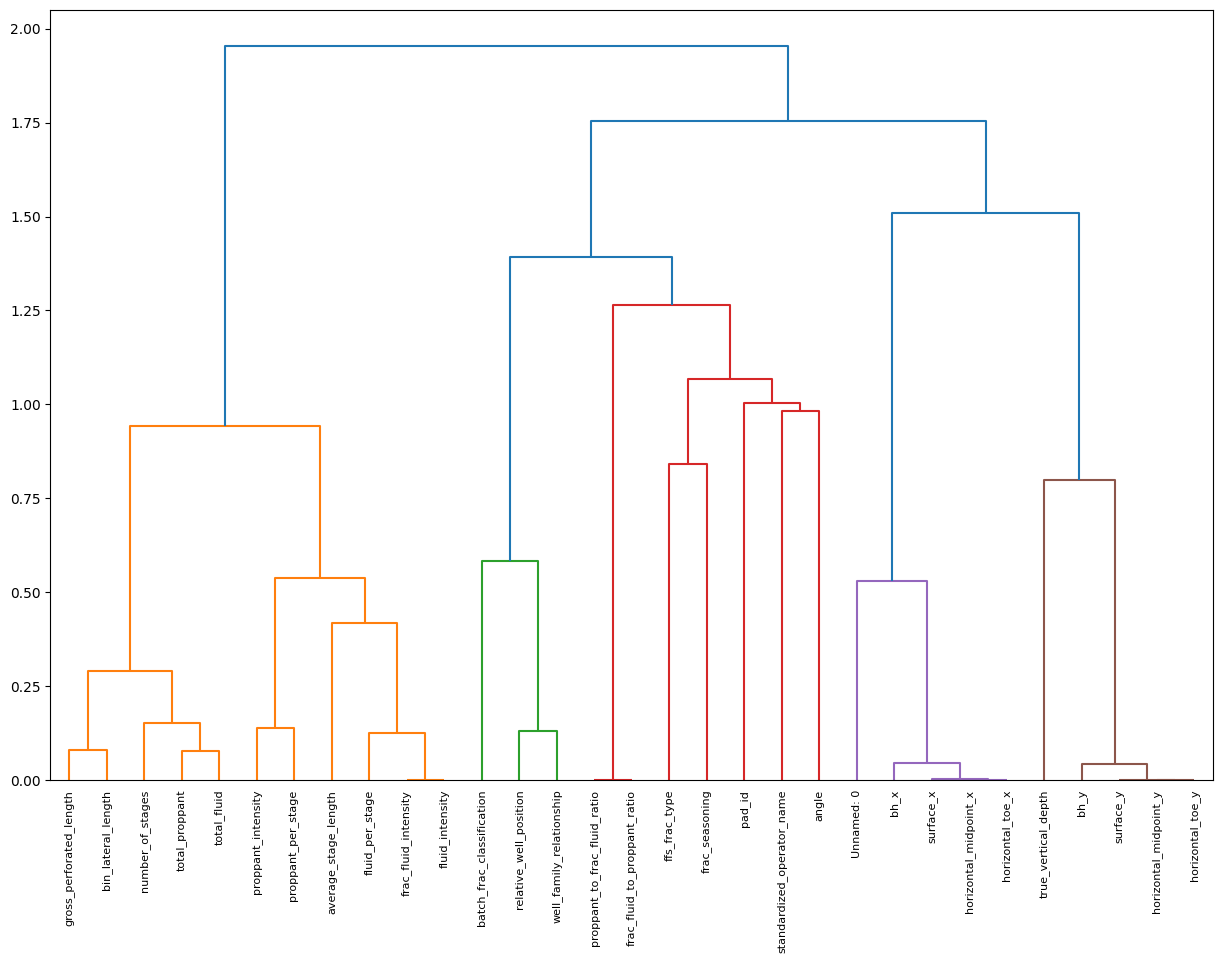

In [5]:

import os
import numpy as np
import pandas as pd
from copy import deepcopy as dc
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr

from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from collections import defaultdict

df_train = data

data_reshaped =  df_train.select_dtypes(include=[np.number]).drop( ['frac_type','OilPeakRate'], axis = 1)
# Compute Spearman rank-order correlation matrix directly on reshaped data
corr, _ = spearmanr(data_reshaped, axis=0)

# Ensuring the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# Convert correlation matrix to a distance matrix
distance_matrix = 1 - np.abs(corr)

# Perform hierarchical clustering using Ward's linkage
dist_linkage = hierarchy.ward(squareform(distance_matrix))

# Outputting shapes for verification
dist_linkage.shape, data_reshaped.shape

import matplotlib.pyplot as plt


# Plot the dendrogram
fig, ax1 = plt.subplots(figsize=(15, 10))
dendro = hierarchy.dendrogram( dist_linkage, labels=list(data_reshaped.columns),  # Using feature names from 'mean_std_all' DataFrame
    ax=ax1, leaf_rotation=90)


## VIF

In [6]:
from typing import Any
import pandas as pd
import numpy as np
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant

from statsmodels.stats.outliers_influence import variance_inflation_factor
df_numeric = df_train.select_dtypes(include=[np.number]).drop( 'frac_type', axis = 1)
df_vif = add_constant(df_numeric)


In [8]:
vif_data = pd.DataFrame()
vif_data["feature"] = df_vif.columns
vif_data["VIF"] = [variance_inflation_factor(df_vif.values, i) for i in range(df_vif.shape[1])]

c:\Users\sgnka\anaconda3\envs\onnx\lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [9]:
vif_data

,feature,VIF
0,const,1.177198e+03
1,Unnamed: 0,2.256556e+00
2,surface_x,1.215450e+03
3,surface_y,1.507854e+03
4,bh_x,1.436640e+01
5,bh_y,1.958854e+01
6,standardized_operator_name,1.073042e+00
7,gross_perforated_length,3.258884e+01
8,number_of_stages,2.898103e+01
9,total_proppant,5.916539e+01


In [7]:



# add standard scalar
from sklearn.preprocessing import StandardScaler

features = data.drop(columns=['OilPeakRate'])
target = data['OilPeakRate']

scaler = StandardScaler()
features = scaler.fit_transform(features.values)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
# Create the Random Forest model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Predict using tahe model
rf_predictions = rf_model.predict(X_test)

# Evaluate the model
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_rmse = np.sqrt(rf_mse)
rf_r2_score = r2_score(y_test, rf_predictions)

print("Random Forest RMSE:", rf_rmse)
print("Random Forest R2 Score:", rf_r2_score)


KeyboardInterrupt: 

In [ ]:
import shap
shap_values = shap.TreeExplainer(rf_model).shap_values(X_test)
shap_interaction_values = shap.TreeExplainer(rf_model).shap_interaction_values(
    X_test
)
shap.summary_plot(shap_values, X_test, plot_type="bar", feature_names=df_train.drop(columns=['OilPeakRate']).columns)